<a href="https://colab.research.google.com/github/Nataliia-Kaguia/goit-ds-hw/blob/main/hw_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Імпорти й налаштування

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
# Параметри та завантаження даних

# Гіперпараметри (можете змінювати)
vocab_size = 20000   # кількість найчастіше вживаних слів
maxlen = 200         # максимальна довжина рецензії (токенів) — обрізаємо/доповнюємо
embedding_dim = 128
batch_size = 128
epochs = 5           # для швидкого тестування, можна збільшити до 8-10

# Завантажуємо датасет IMDB (він уже в Keras)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

# Padding / Truncation
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test  = pad_sequences(x_test,  maxlen=maxlen, padding='post', truncating='post')

print("Train shape:", x_train.shape, "Test shape:", x_test.shape)
print("Example sequence (first):", x_train[0][:20], "... label:", y_train[0])


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape: (25000, 200) Test shape: (25000, 200)
Example sequence (first): [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25] ... label: 1


In [ ]:
# Універсальна функція для побудови моделей

def build_simple_rnn(vocab_size, embedding_dim, maxlen):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        layers.SimpleRNN(64),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(vocab_size, embedding_dim, maxlen):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        layers.LSTM(64),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_bi_lstm(vocab_size, embedding_dim, maxlen):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_stacked_lstm(vocab_size, embedding_dim, maxlen):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Тренувальна функція з callback-ами (EarlyStopping)

es = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def train_and_eval(name, model):
    print("\n=== Training:", name, "===\n")
    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=1
    )
    # Оцінка
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nTest loss: {loss:.4f}, Test accuracy: {acc:.4f}")
    # Прогнози
    y_pred_proba = model.predict(x_test, batch_size=256, verbose=0).ravel()
    y_pred = (y_pred_proba >= 0.5).astype(int)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))
    return history, y_pred, y_pred_proba


In [ ]:
# Навчання та оцінка всіх моделей (по черзі)
# Примітка: тренування чотирьох моделей може зайняти деякий час. Якщо потрібно швидко — поставте epochs=2 чи зменшіть vocab_size/maxlen/batch_size.

histories = {}
predictions = {}

# 1) Simple RNN
model_rnn = build_simple_rnn(vocab_size, embedding_dim, maxlen)
hist_rnn, ypred_rnn, yprob_rnn = train_and_eval("SimpleRNN", model_rnn)
histories['SimpleRNN'] = hist_rnn
predictions['SimpleRNN'] = (ypred_rnn, yprob_rnn)

# 2) LSTM
model_lstm = build_lstm(vocab_size, embedding_dim, maxlen)
hist_lstm, ypred_lstm, yprob_lstm = train_and_eval("LSTM", model_lstm)
histories['LSTM'] = hist_lstm
predictions['LSTM'] = (ypred_lstm, yprob_lstm)

# 3) Bidirectional LSTM
model_bi = build_bi_lstm(vocab_size, embedding_dim, maxlen)
hist_bi, ypred_bi, yprob_bi = train_and_eval("Bidirectional LSTM", model_bi)
histories['BiLSTM'] = hist_bi
predictions['BiLSTM'] = (ypred_bi, yprob_bi)

# 4) Stacked LSTM
model_stacked = build_stacked_lstm(vocab_size, embedding_dim, maxlen)
hist_stacked, ypred_stacked, yprob_stacked = train_and_eval("Stacked LSTM", model_stacked)
histories['StackedLSTM'] = hist_stacked
predictions['StackedLSTM'] = (ypred_stacked, yprob_stacked)



=== Training: SimpleRNN ===

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.4968 - loss: 0.6971 - val_accuracy: 0.5010 - val_loss: 0.6975
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.6424 - loss: 0.6235 - val_accuracy: 0.4938 - val_loss: 0.7078
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.7096 - loss: 0.4678 - val_accuracy: 0.5060 - val_loss: 0.8604

Test loss: 0.6960, Test accuracy: 0.5066

Classification report:
              precision    recall  f1-score   support

           0     0.5679    0.0549    0.1001     12500
           1     0.5034    0.9582    0.6601     12500

    accuracy                         0.5066     25000
   macro avg     0.5357    0.5066    0.3801     25000
weighted avg     0.5357    0.5066    0.3801     25000


=== Training: LSTM ===

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 404ms/step - accuracy: 0.5188 - loss: 0.6921 - val_accuracy: 0.7372 - val_loss: 0.5994
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 410ms/step - accuracy: 0.6441 - loss: 0.6590 - val_accuracy: 0.6262 - val_loss: 0.6561
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 404ms/step - accuracy: 0.6348 - loss: 0.6413 - val_accuracy: 0.6362 - val_loss: 0.6463

Test loss: 0.6069, Test accuracy: 0.7232

Classification report:
              precision    recall  f1-score   support

           0     0.7182    0.7346    0.7263     12500
           1     0.7284    0.7118    0.7200     12500

    accuracy                         0.7232     25000
   macro avg     0.7233    0.7232    0.7232     25000
weighted avg     0.7233    0.7232    0.7232     25000


=== Training: Bidirectional LSTM ===

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 120s 741ms/step - accuracy: 0.6526 - loss: 0.5938 - val_accuracy: 0.8524 - val_loss: 0.3672
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 115s 732ms/step - accuracy: 0.8897 - loss: 0.2905 - val_accuracy: 0.8732 - val_loss: 0.3128
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 146s 757ms/step - accuracy: 0.9391 - loss: 0.1714 - val_accuracy: 0.8542 - val_loss: 0.3887
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 139s 740ms/step - accuracy: 0.9533 - loss: 0.1339 - val_accuracy: 0.8576 - val_loss: 0.4194

Test loss: 0.3643, Test accuracy: 0.8417

Classification report:
              precision    recall  f1-score   support

           0     0.8229    0.8709    0.8462     12500
           1     0.8629    0.8126    0.8370     12500

    accuracy                         0.8417     25000
   macro avg     0.8429    0.8417    0.8416     25000
weighted avg     0.8429    0.8417    0.8416     25000


=== Training: Stacked LSTM ===

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 87s 527ms/step - accuracy: 0.5135 - loss: 0.6905 - val_accuracy: 0.5606 - val_loss: 0.6779
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 145s 546ms/step - accuracy: 0.5535 - loss: 0.6831 - val_accuracy: 0.5696 - val_loss: 0.6758
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 545ms/step - accuracy: 0.5755 - loss: 0.6708 - val_accuracy: 0.7230 - val_loss: 0.5935
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 533ms/step - accuracy: 0.6725 - loss: 0.6201 - val_accuracy: 0.5234 - val_loss: 0.6799
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 547ms/step - accuracy: 0.6873 - loss: 0.5704 - val_accuracy: 0.7582 - val_loss: 0.5148

Test loss: 0.5419, Test accuracy: 0.7433

Classification report:
              precision    recall  f1-score   support

           0     0.7060    0.8338    0.7646     12500
           1     0.7971    0.6527    0.7177     12500

    accuracy                         0.7433     25000
   macro avg     0.7515    0.7433    0.7412     25000
weighted avg     0.

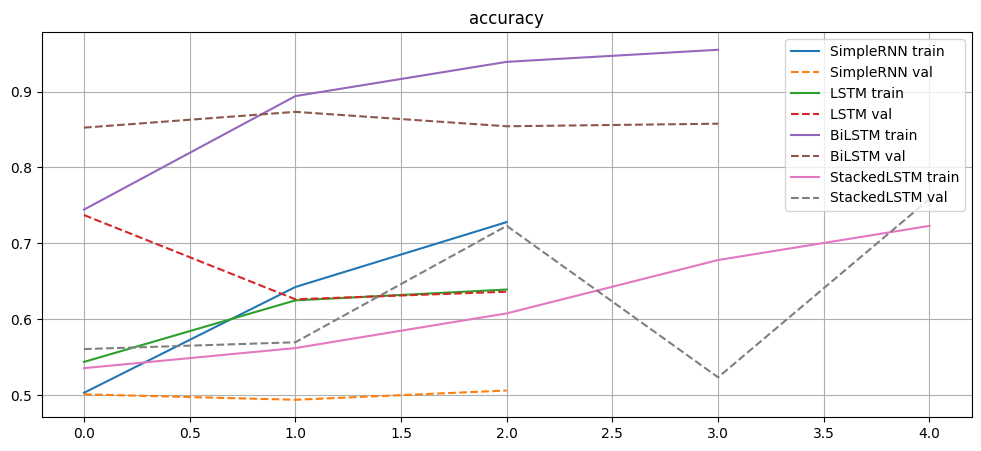

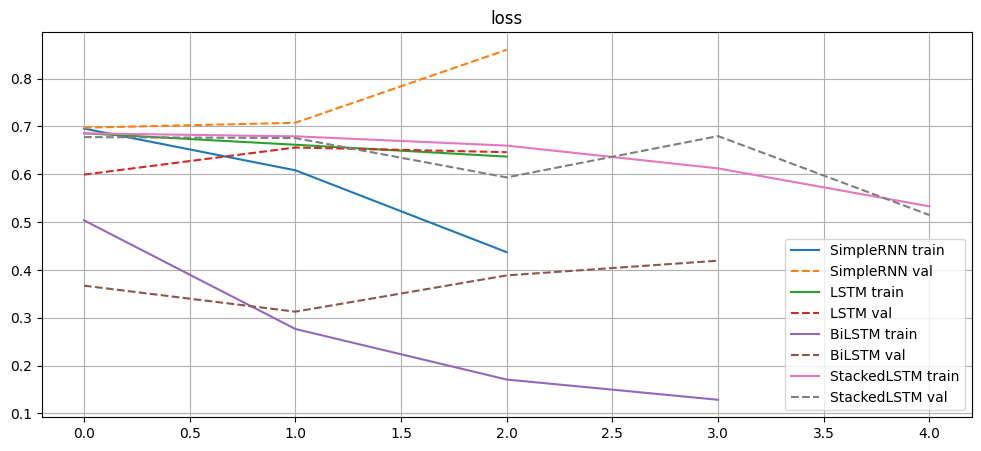

In [ ]:
# Побудова порівняльних графіків (training/validation loss & accuracy)

def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(12,5))
    for name, hist in histories.items():
        plt.plot(hist.history[metric], label=f"{name} train")
        plt.plot(hist.history['val_' + metric], '--', label=f"{name} val")
    plt.title(metric)
    plt.legend()
    plt.grid()
    plt.show()

plot_history({'SimpleRNN': hist_rnn, 'LSTM': hist_lstm, 'BiLSTM': hist_bi, 'StackedLSTM': hist_stacked}, metric='accuracy')
plot_history({'SimpleRNN': hist_rnn, 'LSTM': hist_lstm, 'BiLSTM': hist_bi, 'StackedLSTM': hist_stacked}, metric='loss')


Confusion matrix for: SimpleRNN


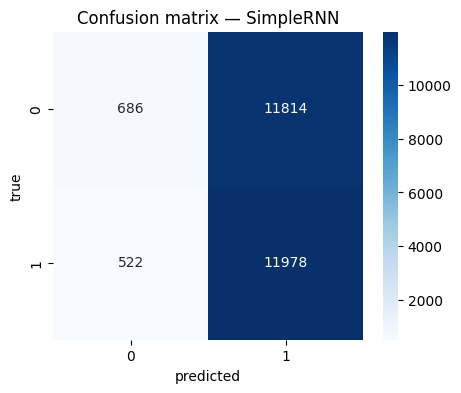

Confusion matrix for: LSTM


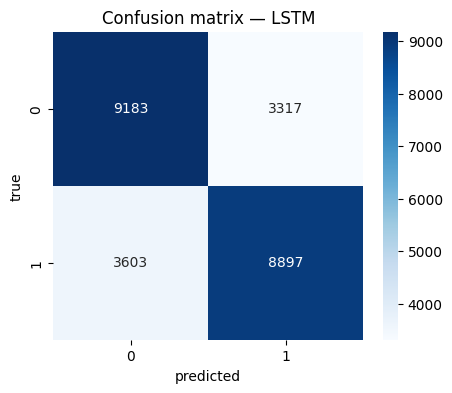

Confusion matrix for: BiLSTM


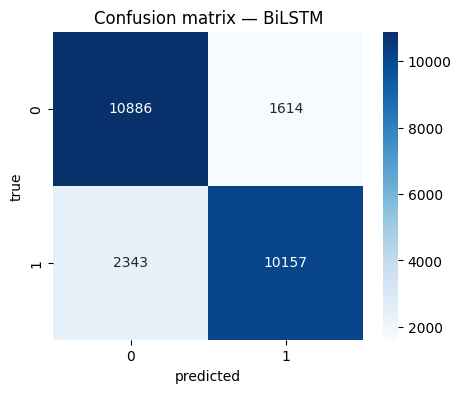

Confusion matrix for: StackedLSTM


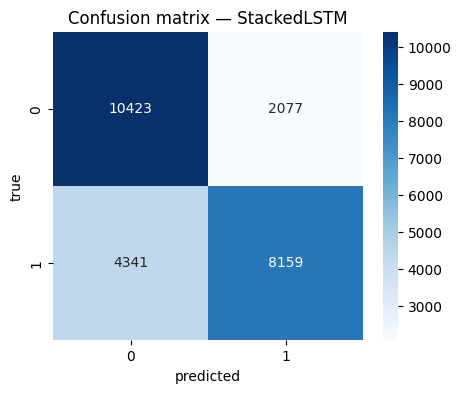

In [ ]:
# Матриці плутанини для кожної моделі (визуалізація)

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.show()

for name, (ypred, yprob) in predictions.items():
    print("Confusion matrix for:", name)
    plot_confusion(y_test, ypred, f"Confusion matrix — {name}")
